In [11]:
import tensorflow as tf
import tensorflow_probability as tfp
tfk = tf.keras
tfd = tfp.distributions

import numpy as np
import matplotlib.pyplot as plt

from utils import eq_covariance,              \
                  sample_1d_datasets_from_gp

In [70]:
x_min = -4.
x_max = 4.
num_datasets = 16
num_datapoints = 50
scale = 1e0
cov_coeff = 1e0
noise_coeff = 1e-1
                        
x, y = sample_1d_datasets_from_gp(x_min=x_min,
                                  x_max=x_max,
                                  num_datasets=num_datasets,
                                  num_datapoints=num_datapoints,
                                  scale=scale,
                                  cov_coeff=cov_coeff,
                                  noise_coeff=noise_coeff)

x, y = x[..., None], y[..., None]

(16, 50, 50)


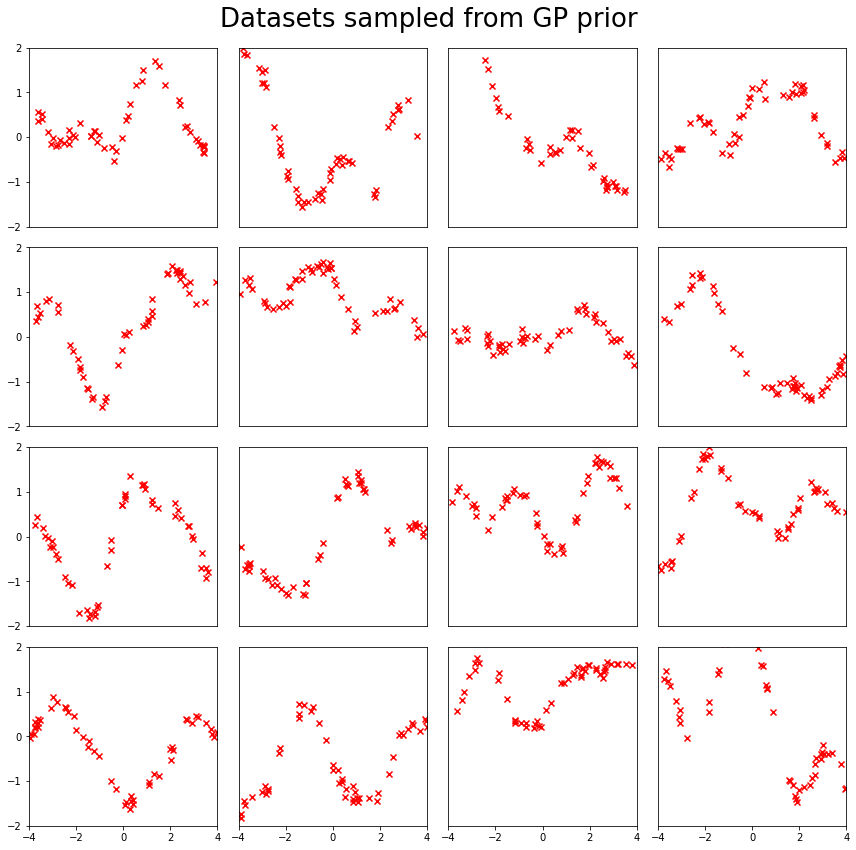

In [71]:
plt.figure(figsize=(12, 12))

for i in range(16):
    
    plt.subplot(4, 4, i + 1)
    plt.scatter(x[i, :, 0], y[i, :, 0], marker='x', color='red')
    
    plt.xlim([-4, 4])
    plt.ylim([-2, 2])
    
    plt.xticks(np.linspace(-4, 4, 5))
    plt.yticks(np.linspace(-2, 2, 5))
    
    if i % 4 != 0:
        plt.yticks([])
        
    if i <= 11 != 0:
        plt.xticks([])

plt.suptitle('Datasets sampled from GP prior', fontsize=26)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

We define a CNP to be the collection of an `encoder` and a `decoder` object. The `encoder` will map the context points to a single context vector. The `decoder` will map the context vector and each of the target inputs, to distributions over the target outputs.

In [72]:
class CNP(tfk.Model):
    
    def __init__(self, encoder, decoder, name='cnp', **kwargs):
        
        
        super().__init__(name=name, **kwargs)
        
        self.encoder = encoder
        self.decoder = decoder
        
        
    def __call__(self, xc, yc, xt):
        
        r = self.encoder(xc, yc)
        yt_dist = self.decoder(r, xt)
        
        return yt_dist
    
    
    def loss(self, xc, yc, xt, yt):
        
        # All axes excluding dataset and batch dimension
        feature_axes = tf.range(yt.shape[0])[2:]
        
        yt_dist = self.__call__(xc, yc, xt)
        
        yt_loglik = yt_dist.log_prob(yt)
        yt_loglik = tf.reduce_sum(yt_loglik, axis=feature_axes)
    
        return yt_log_lik

In [73]:
class FeedforwardNetwork(tf.Module):
    
    def __init__(self,
                 input_dim,
                 output_dim,
                 hidden_dims,
                 nonlinearity,
                 name='feedforward_netork',
                 **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        shapes = [input_dim] + hidden_dims + [output_dim]
        shapes = [(s1, s2) for s1, s2 in zip(shapes[:-1], shapes[1:])]
        
        self.W = []
        self.b = []
        self.num_linear = len(self.W)
        
        with self.name_scope:
            for shape in shapes:
                
                W = tf.Variable(tf.random.normal(shape=shape)) / shape[-1] ** 0.5
                b = tf.Variable(tf.random.normal(shape=shape[1:]))
                
                self.W.append(W)
                self.b.append(b)
        
        self.nonlinearity = getattr(tf.nn, nonlinearity)
        
    
    def __call__(self, tensor):
        
        for W, b in zip(self.W, self.b):
            
            tensor = tf.einsum('...i, ij -> ...j', tensor, W) + b
            
            if i < self.num_linear - 1:
                tensor = self.nonlinearity(tensor)
        
        return tensor

In [74]:
class NeuralNetworkEncoder(tfk.Model):
    
    def __init__(self, feedforward_network, name='neural_network_encooder', **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.feedforward_network = feedforward_network

    
    def __call__(self, xc, yc):
        
        c = tf.concat([xc, yc], axis=-1)
        r = self.feedforward_network(c)
        r = tf.reduce_sum(r, axis=1, keep_dim=True)
        
        return r
        
        
class NeuralNetworkDecoder(tfk.Model):
    
    def __init__(self, feedforward_network, likelihood, name='neural_network_decooder', **kwargs):
        
        super().__init__(name=name, **kwargs)
        
        self.feedforward_network = feedforward_network
        self.likelihood = likelihood

    
    def __call__(self, xt, r):
        
        xt_r = tf.concat([xt, r], axis=1)
        
        param_tensor = self.feedforward_network(xt_r)
        yt_dist = self.likelihood(param_tensor)
        
        return yt_dist
    
    
class GaussianLikelihood:
    
    def __init__(self):
        self.dist = tfd.Normal
        
    
    def __call__(self, param_tensor):
        
        mean, var = self.reparametrise(param_tensor)
        scale = var ** 0.5
        dist = self.dist(loc=loc, scale=scale)
        
        return dist
        
        
    def reparametrise(self, tensor):
        
        mean = tensor[..., :1]
        var = tf.math.exp(tensor[..., 1:2])
        
        return mean, var
    
    
    def loglik(self, param_tensor, data):
        return self.__call__().log_prob(data)

In [68]:
input_dim = 1
output_dim = 1
hidden_dims = [50, 50, 50]
nonlinearity = 'relu'

encoder_ffn = FeedforwardNetwork(input_dim=input_dim,
                                 output_dim=2,
                                 hidden_dims=hidden_dims,
                                 nonlinearity=nonlinearity)

decoder_ffn = FeedforwardNetwork(input_dim=input_dim,
                                 output_dim=2*output_dim,
                                 hidden_dims=hidden_dims,
                                 nonlinearity=nonlinearity)

decoder_likelihood = GaussianLikelihood()

encoder = NeuralNetworkEncoder(feedforward_network=encoder_ffn)

decoder = NeuralNetworkDecoder(feedforward_network=decoder_ffn,
                               likelihood=decoder_likelihood)

In [69]:
x.shape, y.shape

(TensorShape([16, 50]), (16, 50))